In [37]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import matplotlib.pyplot as plt

In [38]:
csv_file_path = '/home/lucas/UFOP/ple_2020/analise_midias_sociais/final-work/data/all_candidates_posts_with_identificator.csv'
df_candidates = pd.read_csv(csv_file_path,encoding = 'utf-8')

In [39]:
# convertendo o tipo data que esta como string em objeto no formato data
df_candidates["created_time"] = pd.to_datetime(df_candidates['created_time'])

In [40]:
df_candidates.head(15)

,created_time,id,pre_processed_message,message_min_processed,shares,status_type,full_picture,reactions_like,reactions_haha,reactions_wow,reactions_sad,reactions_angry,reactions_love,has_textual_message,author
0,2019-03-16 21:15:50+00:00,96033897836_10158944569272837,hoje lu comemoramos anos casados ainda apaixon...,hoje lu e eu comemoramos 40 anos de casados ai...,344,added_photos,https://scontent.fplu2-1.fna.fbcdn.net/v/t1.0-...,15515,21,109,2,10,1524,True,alckmin
1,2019-03-13 22:09:50+00:00,96033897836_10158937268622837,alunos funcionarios fuzilados escola publica d...,alunos e funcionarios fuzilados em uma escola ...,120,mobile_status_update,None,2606,2,2,547,6,92,True,alckmin
2,2019-02-27 13:04:22+00:00,96033897836_10158899426707837,nasceu mateo terceiro filho sophia mario herdo...,nasceu mateo terceiro filho da sophia e do mar...,201,added_photos,https://scontent.fplu2-1.fna.fbcdn.net/v/t1.0-...,7960,32,22,1,2,712,True,alckmin
3,2019-01-25 23:02:43+00:00,96033897836_10158806072577837,solidariedade familias povo mineiro pensamento...,minha solidariedade com as familias e com o po...,27,mobile_status_update,None,1046,1,1,105,1,38,True,alckmin
4,2018-11-09 00:21:08+00:00,96033897836_10158590520182837,celebrando vida familia agradeco todos felicit...,celebrando a vida com a familia . agradeco a t...,108,added_photos,https://scontent.fplu2-1.fna.fbcdn.net/v/t1.0-...,3485,17,8,0,3,306,True,alckmin
5,2018-10-30 01:28:15+00:00,96033897836_10158561677027837,comecou mal defesa liberdade ficou discurso on...,comecou mal . a defesa da liberdade ficou no d...,5174,mobile_status_update,None,14222,2279,108,208,638,1528,True,alckmin
6,2018-10-29 00:56:57+00:00,96033897836_10158558725992837,hora felicitar todos eleitos faco pessoa presi...,e hora de felicitar todos os eleitos e o faco ...,1031,mobile_status_update,None,10482,98,22,7,18,780,True,alckmin
7,2018-10-10 20:33:56+00:00,96033897836_10158506125162837,ouvimos ontem todo partido decidimos liberar m...,ouvimos ontem todo o partido e decidimos liber...,193,added_photos,https://scontent.fplu2-1.fna.fbcdn.net/v/t1.0-...,2112,55,18,26,251,225,True,alckmin
8,2018-10-08 15:25:15+00:00,96033897836_10158499514447837,obrigado todos acreditaram projeto depositaram...,obrigado a todos que acreditaram em nosso proj...,402,added_photos,https://scontent.fplu2-1.fna.fbcdn.net/v/t1.0-...,7401,128,9,434,19,615,True,alckmin
9,2018-10-07 00:00:01+00:00,96033897836_10158493056542837,domingo vai escolher presidente voto ajudara d...,domingo voce vai escolher muito mais do que um...,383,added_video,https://scontent.fplu2-1.fna.fbcdn.net/v/t15.5...,1935,96,7,3,20,176,True,alckmin


In [41]:
n_total_posts = len(df_candidates)
print('número total de posts: {0}'.format(str(n_total_posts)))

número total de posts: 21361


In [42]:
n_posts_with_textual_messages = df_candidates[df_candidates.has_textual_message == True].shape[0]
n_posts_without_textual_messages = df_candidates[df_candidates.has_textual_message == False].shape[0]

print('número de posts com mensagens textuais: {0}'.format(str(n_posts_with_textual_messages)))
print('número de posts sem mensagens textuais: {0}'.format(str(n_posts_without_textual_messages)))

número de posts com mensagens textuais: 19589
número de posts sem mensagens textuais: 1772


In [45]:
#============================================================================================
# realizando o tf idf no df['pre_processed_message'] do corpus inteiro
#============================================================================================

# tf idf é uma medida estatística que tem o intuito de indicar a importância de uma palavra 
# de um documento em relação a uma coleção de documentos ou em um corpus linguístico.

def sort_columns(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)


def extract_top_n_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    sorted_items = sorted_items[:topn]
    score_vals = []
    feature_vals = []
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    return results

cv = CountVectorizer()

word_count_vector=cv.fit_transform(df_candidates['pre_processed_message'])

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

# you only needs to do this once, this is a mapping of index to 
feature_names=cv.get_feature_names()

# get the document that we want to extract keywords from
corpus=' '.join(df_candidates['pre_processed_message'])

#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform([corpus]))

#sort the tf-idf vectors by descending order of scores
sorted_items=sort_columns(tf_idf_vector.tocoo())

#extract only the top n; n here is 10
keywords=extract_top_n_from_vector(feature_names,sorted_items,10)

print("\n===Keywords===")
for key in keywords:
    print(key,keywords[key])


===Keywords===
brasil 0.209
hoje 0.156
governo 0.137
paulo 0.128
novo 0.125
pais 0.123
todos 0.12
ser 0.111
estado 0.105
bolsonaro 0.104


In [46]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

brasil : 4535
hoje : 3117
governo : 2291
paulo : 2233
pais : 2079
todos : 2060
novo : 2040
ser : 1776
estado : 1674
dia : 1668
bolsonaro : 1636
vamos : 1471
marina : 1465
politica : 1440
contra : 1436


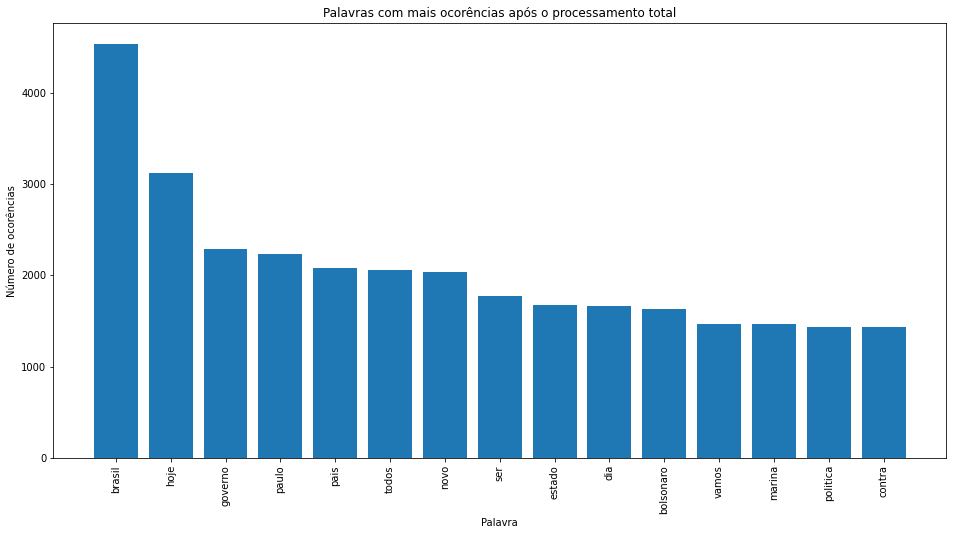

In [48]:
#=======================================================================
# visualização das top palavras de todos os candidatos
#=======================================================================

count_vectorizer = CountVectorizer()
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df_candidates['pre_processed_message'])

for index in range(len(word_values)):
    print('{0} : {1}'.format(str(words[index]),str(word_values[index])))
    
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Palavras com mais ocorências após o processamento total');
ax.set_xlabel('Palavra');
ax.set_ylabel('Número de ocorências');
plt.show()


In [49]:
#=======================================================================
# filtrando os posts do alckmin
#=======================================================================
author_mask = (df_candidates['author'] == 'alckmin')

df_alckmin = df_candidates[author_mask]

In [ ]:
#=======================================================================
# número de posts do alckmin
#=======================================================================
df_alckmin.count()

hoje : 1362
paulo : 897
estado : 828
brasil : 736
geraldo : 664
mil : 579
sp : 561
obras : 539
vai : 510
grande : 467


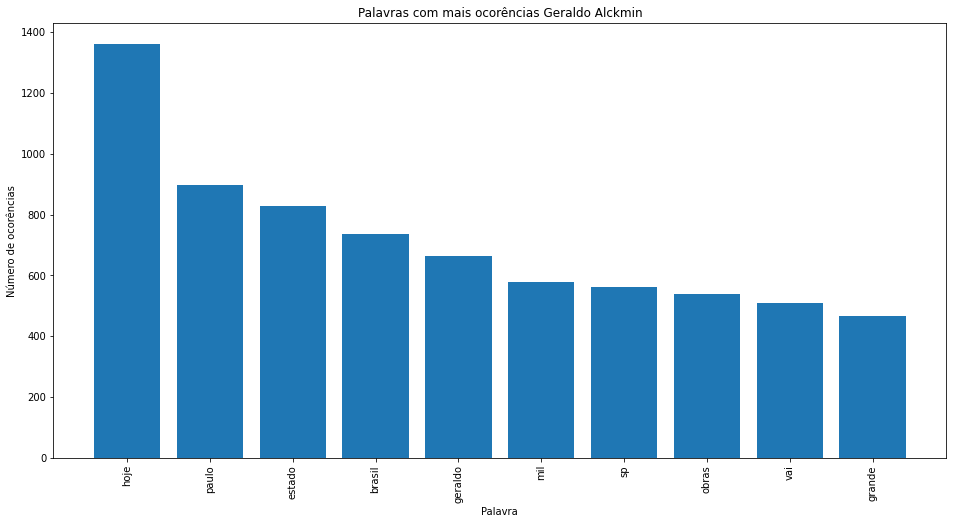

In [83]:
#=======================================================================
# visualização das top palavras do alckmin
#=======================================================================

count_vectorizer = CountVectorizer()
words, word_values = get_top_n_words(n_top_words=10,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df_alckmin['pre_processed_message'])

for index in range(len(word_values)):
    print('{0} : {1}'.format(str(words[index]),str(word_values[index])))
    
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Palavras com mais ocorências Geraldo Alckmin');
ax.set_xlabel('Palavra');
ax.set_ylabel('Número de ocorências');
plt.show()


In [54]:
#=======================================================================
# filtrando os posts do amoedo
#=======================================================================
author_mask = (df_candidates['author'] == 'amoedo')

df_amoedo = df_candidates[author_mask]

In [55]:
#=======================================================================
# número de posts do amoedo
#=======================================================================
df_amoedo.count()

created_time             2249
id                       2249
pre_processed_message    2249
message_min_processed    2249
shares                   2249
status_type              2249
full_picture             2249
reactions_like           2249
reactions_haha           2249
reactions_wow            2249
reactions_sad            2249
reactions_angry          2249
reactions_love           2249
has_textual_message      2249
author                   2249
dtype: int64

novo : 1393
brasil : 788
pais : 377
governo : 373
todos : 371
ser : 349
estado : 342
cidadao : 328
dinheiro : 299
politica : 263


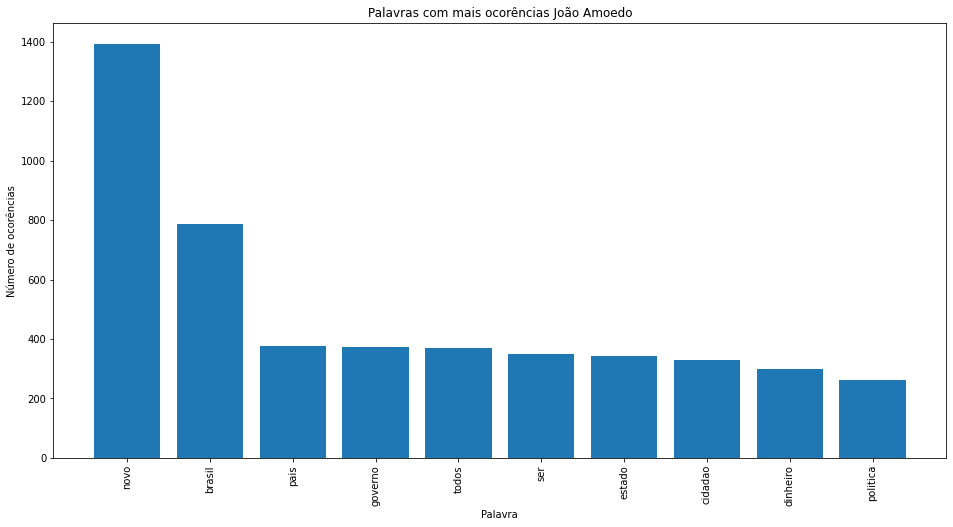

In [82]:
#=======================================================================
# visualização das top palavras do amoedo
#=======================================================================

count_vectorizer = CountVectorizer()
words, word_values = get_top_n_words(n_top_words=10,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df_amoedo['pre_processed_message'])

for index in range(len(word_values)):
    print('{0} : {1}'.format(str(words[index]),str(word_values[index])))
    
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Palavras com mais ocorências João Amoedo');
ax.set_xlabel('Palavra');
ax.set_ylabel('Número de ocorências');
plt.show()


In [84]:
#=======================================================================
# filtrando os posts do bolsonaro
#=======================================================================
author_mask = (df_candidates['author'] == 'bolsonaro')

df_bolsonaro = df_candidates[author_mask]

In [85]:
#=======================================================================
# contagem de posts do bolsonaro
#=======================================================================
df_bolsonaro.count()


created_time             3646
id                       3646
pre_processed_message    3646
message_min_processed    3646
shares                   3646
status_type              3646
full_picture             3646
reactions_like           3646
reactions_haha           3646
reactions_wow            3646
reactions_sad            3646
reactions_angry          3646
reactions_love           3646
has_textual_message      3646
author                   3646
dtype: int64

bolsonaro : 1098
brasil : 942
jair : 441
todos : 390
pt : 349
governo : 310
obrigado : 260
hoje : 256
ministerio : 244
presidente : 232


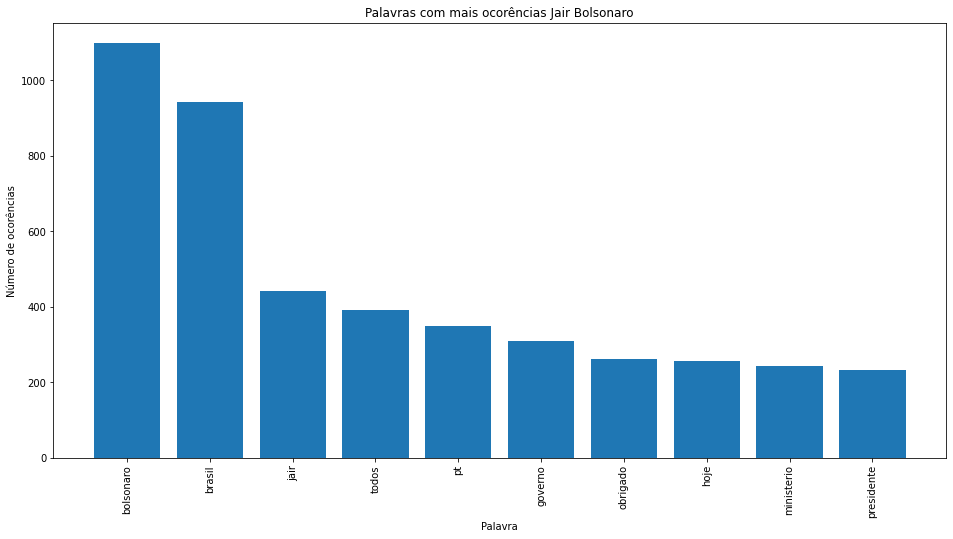

In [86]:
#=======================================================================
# visualização das top palavras do bolsonaro
#=======================================================================

count_vectorizer = CountVectorizer()
words, word_values = get_top_n_words(n_top_words=10,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df_bolsonaro['pre_processed_message'])

for index in range(len(word_values)):
    print('{0} : {1}'.format(str(words[index]),str(word_values[index])))
    
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Palavras com mais ocorências Jair Bolsonaro');
ax.set_xlabel('Palavra');
ax.set_ylabel('Número de ocorências');
plt.show()


In [87]:
#=======================================================================
# filtrando os posts do boulos
#=======================================================================
author_mask = (df_candidates['author'] == 'boulos')

df_boulos = df_candidates[author_mask]

In [88]:
#=======================================================================
# contagem de posts do boulos
#=======================================================================
df_boulos.count()


created_time             2785
id                       2785
pre_processed_message    2785
message_min_processed    2785
shares                   2785
status_type              2785
full_picture             2785
reactions_like           2785
reactions_haha           2785
reactions_wow            2785
reactions_sad            2785
reactions_angry          2785
reactions_love           2785
has_textual_message      2785
author                   2785
dtype: int64

mtst : 530
contra : 467
povo : 402
paulo : 376
hoje : 362
luta : 333
dia : 319
brasil : 309
vamos : 277
aovivo : 276


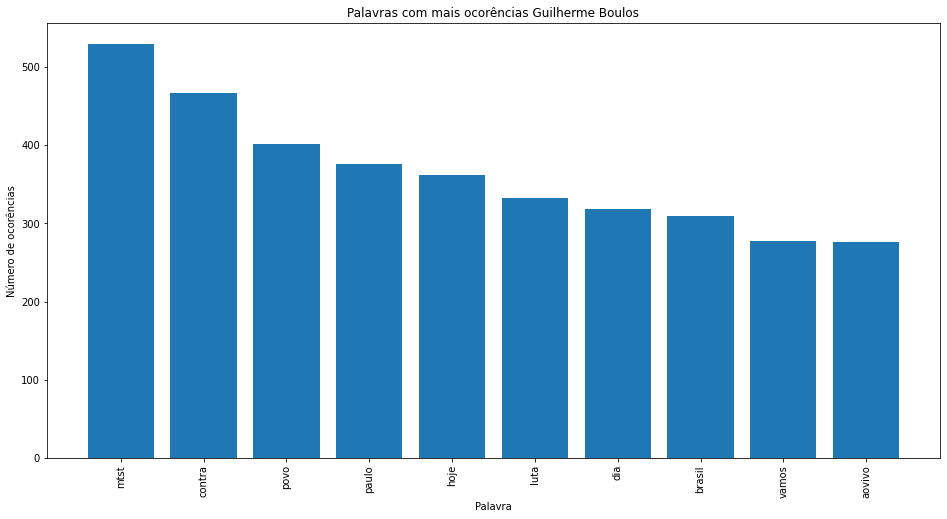

In [89]:
#=======================================================================
# visualização das top palavras do boulos
#=======================================================================

count_vectorizer = CountVectorizer()
words, word_values = get_top_n_words(n_top_words=10,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df_boulos['pre_processed_message'])

for index in range(len(word_values)):
    print('{0} : {1}'.format(str(words[index]),str(word_values[index])))
    
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Palavras com mais ocorências Guilherme Boulos');
ax.set_xlabel('Palavra');
ax.set_ylabel('Número de ocorências');
plt.show()

In [90]:
#=======================================================================
# filtrando os posts do ciro
#=======================================================================
author_mask = (df_candidates['author'] == 'ciro')

df_ciro = df_candidates[author_mask]

In [91]:
#=======================================================================
# contagem de posts do ciro
#=======================================================================
df_ciro.count()

created_time             1683
id                       1683
pre_processed_message    1683
message_min_processed    1683
shares                   1683
status_type              1683
full_picture             1683
reactions_like           1683
reactions_haha           1683
reactions_wow            1683
reactions_sad            1683
reactions_angry          1683
reactions_love           1683
has_textual_message      1683
author                   1683
dtype: int64

ciro : 683
brasil : 456
aovivo : 265
gomes : 230
acompanhe : 226
hoje : 180
pdt : 160
vamos : 144
debate : 122
pais : 121


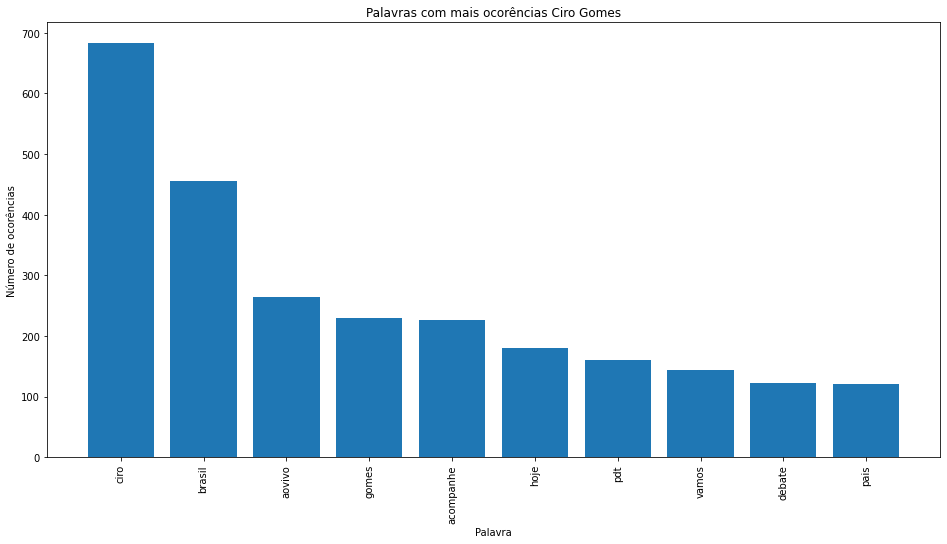

In [92]:
#=======================================================================
# visualização das top palavras do ciro
#=======================================================================

count_vectorizer = CountVectorizer()
words, word_values = get_top_n_words(n_top_words=10,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df_ciro['pre_processed_message'])

for index in range(len(word_values)):
    print('{0} : {1}'.format(str(words[index]),str(word_values[index])))
    
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Palavras com mais ocorências Ciro Gomes');
ax.set_xlabel('Palavra');
ax.set_ylabel('Número de ocorências');
plt.show()

In [93]:
#=======================================================================
# filtrando os posts do haddad
#=======================================================================
author_mask = (df_candidates['author'] == 'haddad')

df_haddad = df_candidates[author_mask]

In [94]:
#=======================================================================
# contagem de posts do haddad
#=======================================================================
df_haddad.count()

created_time             1880
id                       1880
pre_processed_message    1880
message_min_processed    1880
shares                   1880
status_type              1880
full_picture             1880
reactions_like           1880
reactions_haha           1880
reactions_wow            1880
reactions_sad            1880
reactions_angry          1880
reactions_love           1880
has_textual_message      1880
author                   1880
dtype: int64

haddad : 539
paulo : 385
fernando : 335
cidade : 332
lula : 303
brasil : 191
haddadpresidente : 169
hoje : 160
educacao : 150
candidato : 135


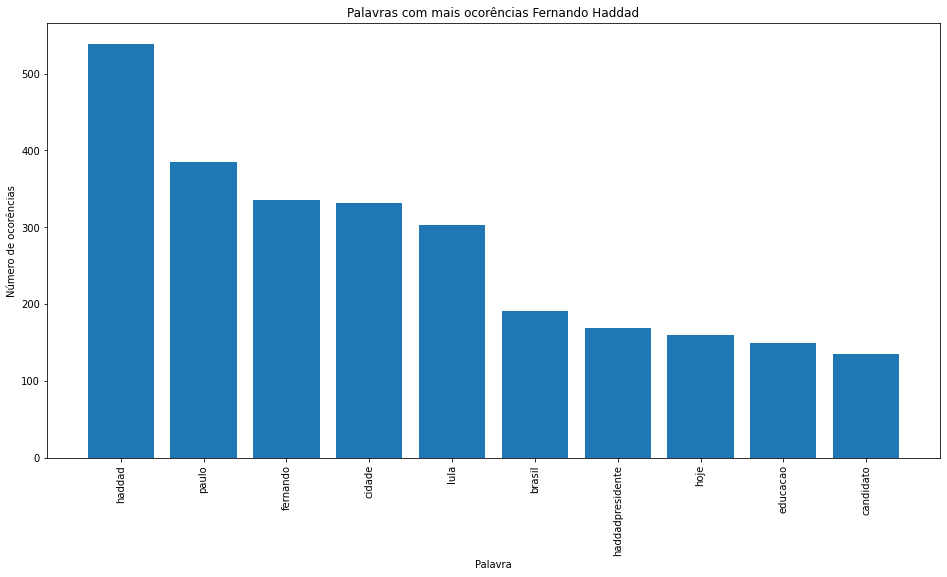

In [95]:
#=======================================================================
# visualização das top palavras do haddad
#=======================================================================

count_vectorizer = CountVectorizer()
words, word_values = get_top_n_words(n_top_words=10,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df_haddad['pre_processed_message'])

for index in range(len(word_values)):
    print('{0} : {1}'.format(str(words[index]),str(word_values[index])))
    
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Palavras com mais ocorências Fernando Haddad');
ax.set_xlabel('Palavra');
ax.set_ylabel('Número de ocorências');
plt.show()

In [96]:
#=======================================================================
# filtrando os posts da marina
#=======================================================================
author_mask = (df_candidates['author'] == 'marina')

df_marina = df_candidates[author_mask]

In [97]:
#=======================================================================
# contagem de posts da marina
#=======================================================================
df_marina.count()

created_time             5044
id                       5044
pre_processed_message    5044
message_min_processed    5044
shares                   5044
status_type              5044
full_picture             5044
reactions_like           5044
reactions_haha           5044
reactions_wow            5044
reactions_sad            5044
reactions_angry          5044
reactions_love           5044
has_textual_message      5044
author                   5044
dtype: int64

marina : 1447
brasil : 1113
rede : 1008
silva : 902
governo : 877
pais : 733
ser : 729
politica : 683
presidente : 624
hoje : 616


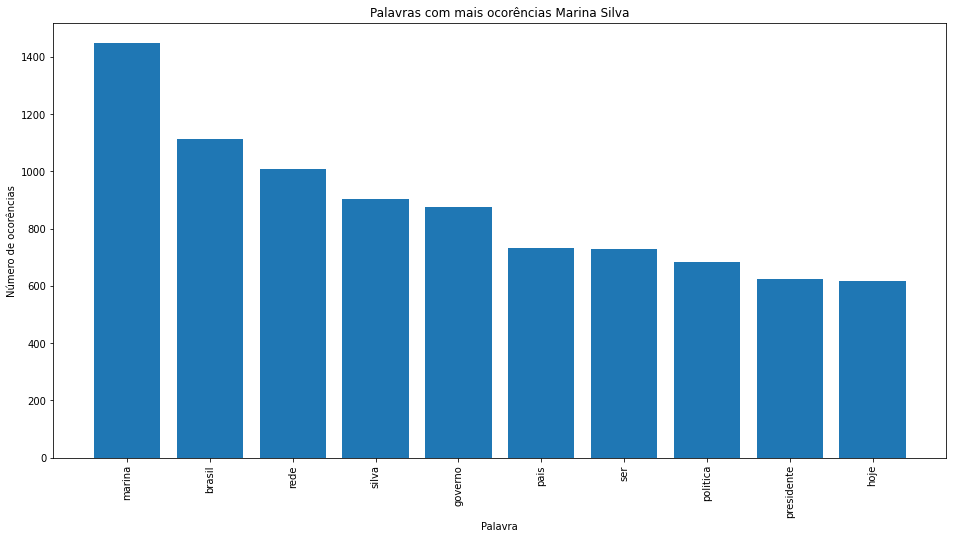

In [98]:
#=======================================================================
# visualização das top palavras da marina
#=======================================================================

count_vectorizer = CountVectorizer()
words, word_values = get_top_n_words(n_top_words=10,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df_marina['pre_processed_message'])

for index in range(len(word_values)):
    print('{0} : {1}'.format(str(words[index]),str(word_values[index])))
    
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Palavras com mais ocorências Marina Silva');
ax.set_xlabel('Palavra');
ax.set_ylabel('Número de ocorências');
plt.show()